In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip "/content/drive/MyDrive/Indian Landmark Detection Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/33.jpg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/34.jpeg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/34.jpg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/345trf.jpeg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/34fv.jpeg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/35.jpeg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/35.jpg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/36.jpeg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/36.jpg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/37.jpg  
  inflating: archive - Copy/Indian-monuments/images/train/golden temple/38.jpeg  
  inflating: archive - Copy/Indian-monuments/i

In [6]:
import os

for dirpath, dirnames, filenames in os.walk("/content/archive - Copy/Indian-monuments/images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/archive - Copy/Indian-monuments/images'.
There are 24 directories and 0 images in '/content/archive - Copy/Indian-monuments/images/test'.
There are 0 directories and 45 images in '/content/archive - Copy/Indian-monuments/images/test/India_gate'.
There are 0 directories and 40 images in '/content/archive - Copy/Indian-monuments/images/test/Sun Temple Konark'.
There are 0 directories and 81 images in '/content/archive - Copy/Indian-monuments/images/test/Hawa mahal'.
There are 0 directories and 30 images in '/content/archive - Copy/Indian-monuments/images/test/Gateway of India'.
There are 0 directories and 34 images in '/content/archive - Copy/Indian-monuments/images/test/Ellora Caves'.
There are 0 directories and 34 images in '/content/archive - Copy/Indian-monuments/images/test/Charar-E- Sharif'.
There are 0 directories and 65 images in '/content/archive - Copy/Indian-monuments/images/test/golden temple'.
There are 0 directories and 31 i

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/archive - Copy/Indian-monuments/images/train/"
test_dir = "/content/archive - Copy/Indian-monuments/images/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 7909 images belonging to 24 classes.
Testing images:
Found 1045 images belonging to 24 classes.


In [8]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [9]:
! pip install tensorflow_hub

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [11]:

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [12]:
def create_model(model_url, num_classes=24):


  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

In [15]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [18]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])


efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240512-120208
Epoch 1/5
248/248 [==============================] - 465s 2s/step - loss: 1.3141 - accuracy: 0.6969 - val_loss: 2.6118 - val_accuracy: 0.5301
Epoch 2/5
248/248 [==============================] - 448s 2s/step - loss: 0.6074 - accuracy: 0.8622 - val_loss: 2.9767 - val_accuracy: 0.5378
Epoch 3/5
248/248 [==============================] - 447s 2s/step - loss: 0.4609 - accuracy: 0.8911 - val_loss: 3.1887 - val_accuracy: 0.5445
Epoch 4/5
248/248 [==============================] - 456s 2s/step - loss: 0.3803 - accuracy: 0.9114 - val_loss: 3.3660 - val_accuracy: 0.5426
Epoch 5/5
248/248 [==============================] - 492s 2s/step - loss: 0.3254 - accuracy: 0.9236 - val_loss: 3.5226 - val_accuracy: 0.5445


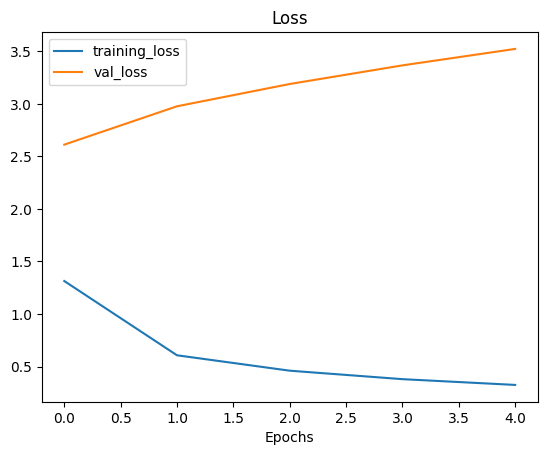

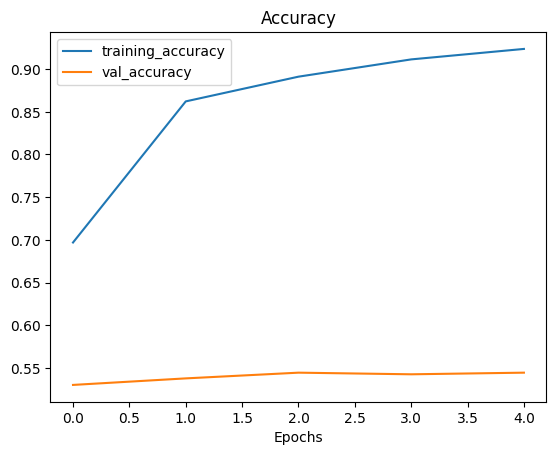

In [19]:
plot_loss_curves(efficientnet_history)

In [20]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 24)                30744     
                                                                 
Total params: 4080308 (15.57 MB)
Trainable params: 30744 (120.09 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [21]:
efficientnet_model.save("efficientnet1.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
efficientnet_model.save("/content/drive/MyDrive/efficient-2", save_format="h5")

In [23]:
# Create model
efficientnet_model_50 = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model_50.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history2 = efficientnet_model_50.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=50, # train for 50 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240512-124049
Epoch 1/50
248/248 [==============================] - 454s 2s/step - loss: 1.2884 - accuracy: 0.7063 - val_loss: 2.6359 - val_accuracy: 0.5234
Epoch 2/50
248/248 [==============================] - 438s 2s/step - loss: 0.5971 - accuracy: 0.8631 - val_loss: 2.9521 - val_accuracy: 0.5416
Epoch 3/50
248/248 [==============================] - 450s 2s/step - loss: 0.4545 - accuracy: 0.8943 - val_loss: 3.2102 - val_accuracy: 0.5416
Epoch 4/50
248/248 [==============================] - 436s 2s/step - loss: 0.3770 - accuracy: 0.9106 - val_loss: 3.3744 - val_accuracy: 0.5464
Epoch 5/50
248/248 [==============================] - 464s 2s/step - loss: 0.3233 - accuracy: 0.9264 - val_loss: 3.5098 - val_accuracy: 0.5483
Epoch 6/50
248/248 [==============================] - 441s 2s/step - loss: 0.2832 - accuracy: 0.9353 - val_loss: 3.6166 - val_accuracy: 0.5493
Epoch 7/50
248/248 [==============================] - 434s 2s/s

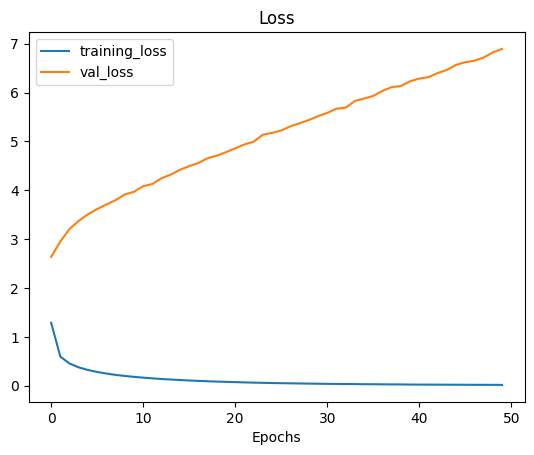

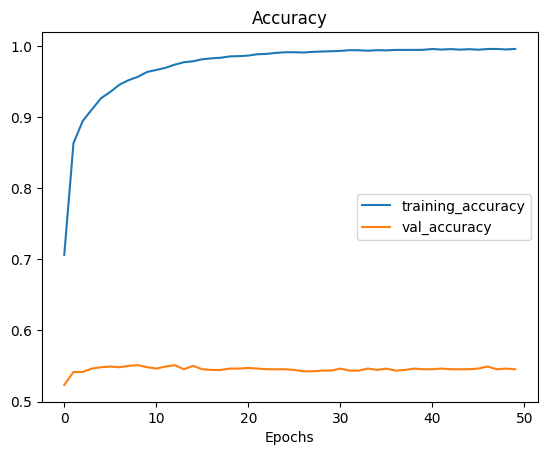

In [24]:
plot_loss_curves(efficientnet_history2)

In [27]:
efficientnet_model_50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 24)                30744     
                                                                 
Total params: 4080308 (15.57 MB)
Trainable params: 30744 (120.09 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
efficientnet_model.save("efficientnet50.h5")


In [ ]:
efficientnet_model.save("/content/drive/MyDrive/efficient-50", save_format="h5")